# Sentiment Analysis on IMDB Movie Reviews

In this analysis, we want to create models which we can train to classify new IMDB reviews into the specified 2 categories (positive/negative review). I created Keras models by loading a data set, preprocessing input data, building a Sequential Keras model and compiling the model with a training configuration. I also created Random Forest models on the training data and evaluated it on the test set. 

In this project, I used Keras, NumPy and Scikit-learn in the IBM Watson Studio. I used Python with Apache Spark Environment with one Worker. 

## Use Case

For IMDB:
- Used to determine the attitude of the reviewer with respect to various topics or the overall polarity of review
- Help in determining which movie should be recommended to a reviewer given that his/her review for a particular movie was negative/positive

For online users: 
- If positive and negative reviews are highlighted in different colors on the IMDB website, users will be able to easily see if the review is positive or negative without reading the entire review. 
- Users would be given recommendatons on the IMDB for next movies to watch, based on the reviews they wrote for other movies. This would significantly enhance user experience. 

## Data Set

We are looking at a dataset of 50,000 movie reviews from IMDB, categorized by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "4" encodes the 4th most frequent word in the data. As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word. This dataset is available through the Keras API.

## Data Quality Assessment and ETL Process

The data quality of the dataset is fairly good. There are no missing datapoints. All features are integers (word frequencies) and the outcome variables takes values 0 or 1. 

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D, Flatten
from keras.utils import to_categorical
seed = 142
np.random.seed(seed)
from keras.datasets import imdb

max_words = 5000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words,seed=seed)

num_classes = np.max(y_train) + 1 # sentiment (positive/negative)

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200122033634-0002
KERNEL_ID = 122146aa-6bb8-4c32-84f3-291b362b5312


Using TensorFlow backend.


I capped the maximum number of words in a review item to 5000 top most frequent words. Also, 50% of the data is test data, meaning that there are 25,000 observations in the train set and 25,000 observations in the test set.

In [2]:
print("x_train dimensions:", x_train.shape)
print("x_test dimensions:", x_train.shape)

x_train dimensions: (25000,)
x_test dimensions: (25000,)


## Data Exploration and Visualization

The outcome variable (review sentiment) has 2 categories: 0 (negative sentiment) and 1 (positive sentiment). There are 4998 unique words in the dataset, confirming that the choice of capping the maximum number of words in a review item to 5000 is reasonable.  

In [3]:
dataX = np.concatenate((x_train, x_test), axis=0)
dataY = np.concatenate((y_train, y_test), axis=0)

print("Categories:", np.unique(dataY)) # Sentiment values (positive/negative)
print("Number of unique words in dataset:", len(np.unique(np.hstack(dataX))))

Categories: [0 1]
Number of unique words in dataset: 4998


In [4]:
x_test[1] # Sample feature; features are sequences of word indexes in form of integers

[1,
 3053,
 312,
 23,
 4,
 1023,
 7,
 4194,
 209,
 6,
 1203,
 385,
 6,
 2,
 2869,
 7,
 102,
 4689,
 14,
 9,
 31,
 7,
 4,
 118,
 6,
 55,
 185,
 2,
 2,
 133,
 17,
 4,
 24,
 66,
 99,
 3206,
 1629,
 4,
 65,
 2,
 53,
 23,
 2,
 7,
 2,
 74,
 101,
 2,
 2,
 4,
 696,
 177,
 9,
 906,
 2,
 4189,
 40,
 35,
 154,
 3348,
 43,
 6,
 65,
 7,
 6,
 185,
 132,
 15,
 659,
 409,
 193,
 27,
 1729,
 76,
 99,
 615]

(array([25000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 25000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

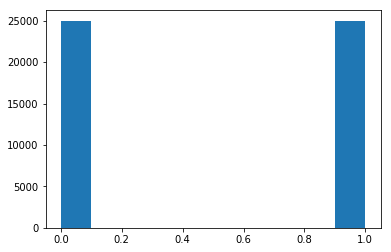

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(dataY) # Distribution of Labels

Based on the hostogram, the dataset is balanced, meaning that itconsists of 50% negative and 50% positive reviews. Based on this consideration, I will be able to use accuracy as the classification model prediction measure. 

## Feature Engineering

The training features are still sequences of indexes. They need to be further preprocess, so that we can plug them into a Dense layer. For this we use a Tokenizer from Keras text preprocessing module. This tokenizer will take an index sequence and map it to a vector of length max_words=5000. Each of the 5000 vector positions corresponds to one of the words in our reviews. The output of the tokenizer has a 1 at the ith position of the vector, if the word corresponding to i is in the review, and 0 otherwise. Even if this word appears multiple times, we still just put a 1 into our vector, i.e. our tokenizer is binary. We use this tokenizer to transform both train and test features below. 

In [6]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')

#### One Hot Encoding

I transformed both train and test label datasets into one-hot encoded vectors of length 2 (sentiment can be either positive or negative).

In [7]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## 2. Models

### DeepLearning Algorithm: Models 1 and 2

I created Convolutional Neural Network models in Keras to classify each film review. I chose Convolutional Neural Network because it has proven very effective in classification problems. 

Model 1: Keras *Sequential* model and added 4 layers to it:

- *Dense* layer with in input_dim=(max_words) and "relu" activation
- *Dropout* layer with dropout rate of 50%
- *Dense* layer with 250 output units and "relu" activation
- *Dense* layer with 2 output units and "sigmoid" activation

Model 2: Keras *Sequential* model and added 3 layers to it:

- *Dense* layer with in input_dim=(max_words) and "relu" activation
- *Dropout* layer with dropout rate of 50%
- *Dense* layer with 2 output units and "softmax" activation

### Machine Learning Algorithm: Models 3 and 4

I created 2 Random Forest models because it is considered as a highly accurate and robust method because of the number of decision trees participating in the process.

Model 3: Random Forest model with n_estimators = 10. 

Model 4: Random Forest model with n_estimators = 100. 



In [8]:
model1 = Sequential() 

model1.add(Dense(max_words, activation = 'relu', input_dim = (max_words)))  
model1.add(Dropout(0.5))
model1.add(Dense(250, activation='relu'))
model1.add(Dense(num_classes, activation ='sigmoid'))

model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5000)              25005000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               1250250   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 502       
Total params: 26,255,752
Trainable params: 26,255,752
Non-trainable params: 0
_________________________________________________________________


In [9]:
model2 = Sequential() 

model2.add(Dense(max_words, activation = 'relu', input_dim = (max_words)))  
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation ='softmax'))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 5000)              25005000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10002     
Total params: 25,015,002
Trainable params: 25,015,002
Non-trainable params: 0
_________________________________________________________________


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve

model3 = RandomForestClassifier(n_estimators=10)

In [11]:
model4 = RandomForestClassifier(n_estimators=100)

## Model Compilation

As the next step, I compile the Keras models with a training configuration. I pick a loss function and an optimizer. Since this is a binary classification problem and the output of our network is a probability, I use the binary_crossentropy loss. I configure the model with the adam optimizer.

In [12]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [13]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## Model Training and Performance Indicator 

I defined the batch_size for training as 64 (usually batch_size between 60 and 80 is optimal) and train the model for 5 epochs on *x_train* and *y_train* by using the *fit* method of your model. Then, I calculated the score for your trained model by running *evaluate* on *x_test* and *y_test* with the same batch size as used in *fit*.

Instructions for updating:
Use tf.cast instead.


Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 148s 6ms/step - loss: 0.3284 - acc: 0.8596 - val_loss: 0.2934 - val_acc: 0.8728
Epoch 2/5
25000/25000 [==============================] - 146s 6ms/step - loss: 0.2193 - acc: 0.9093 - val_loss: 0.3292 - val_acc: 0.8585
Epoch 3/5
25000/25000 [==============================] - 146s 6ms/step - loss: 0.1461 - acc: 0.9394 - val_loss: 0.4016 - val_acc: 0.8715
Epoch 4/5
25000/25000 [==============================] - 145s 6ms/step - loss: 0.0794 - acc: 0.9684 - val_loss: 0.4685 - val_acc: 0.8719
Epoch 5/5
25000/25000 [==============================] - 145s 6ms/step - loss: 0.0393 - acc: 0.9860 - val_loss: 0.5872 - val_acc: 0.8705


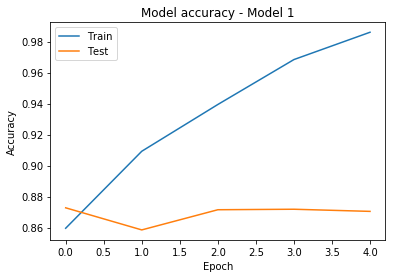

In [14]:
# Model 1
mfit = model1.fit(x_train, y_train, batch_size = 64, epochs = 5, validation_data = (x_test, y_test))
mfit

score = model1.evaluate(x_test, y_test, verbose=0)

import matplotlib.pyplot as plt

# Plot training & validation accuracy values for Model 1
plt.plot(mfit.history['acc'])
plt.plot(mfit.history['val_acc'])
plt.title('Model accuracy - Model 1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 143s 6ms/step - loss: 0.0323 - acc: 0.9918 - val_loss: 0.4093 - val_acc: 0.8729
Epoch 2/5
25000/25000 [==============================] - 142s 6ms/step - loss: 0.0072 - acc: 0.9993 - val_loss: 0.4795 - val_acc: 0.8725
Epoch 3/5
25000/25000 [==============================] - 141s 6ms/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.5372 - val_acc: 0.8716
Epoch 4/5
25000/25000 [==============================] - 142s 6ms/step - loss: 0.0019 - acc: 0.9999 - val_loss: 0.5631 - val_acc: 0.8712
Epoch 5/5
25000/25000 [==============================] - 142s 6ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.5791 - val_acc: 0.8753


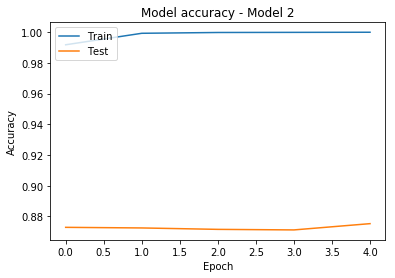

In [16]:
# Model 2
mfit = model2.fit(x_train, y_train, batch_size = 64, epochs = 5, validation_data = (x_test, y_test))
mfit

score = model2.evaluate(x_test, y_test, verbose=0)

# Plot training & validation accuracy values for Model 2
plt.plot(mfit.history['acc'])
plt.plot(mfit.history['val_acc'])
plt.title('Model accuracy - Model 2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
# Model 3
model3.fit(x_train, y_train)
print("Model 3 accuracy:", model3.score(x_test, y_test))

Model 3 accuracy: 0.69804


In [19]:
# Model 4
model4.fit(x_train, y_train)
print("Model 4 accuracy:", model4.score(x_test, y_test))

Model 4 accuracy: 0.83744


In this project, the model performance indicator is accuracy. Accuracy is the ratio of number of correct predictions to the total number of input samples. It is a very simple and intuitive measure, and it works well only if there are equal number of samples belonging to each class. Since my dataset has equal number of samples belonging to each class, I am using accuracy. 

Based on the accuracy measure, out of the models trained, Model 1 seems to perform best (accuracy on test data = 87.3%, accuracy on train data = 86%). It does not seem to be overfitting. Therefore, Model 1 is chosen as the final model.

## Model Deployment

The insights from the model can be encapsuled behind an API that would be consumed by IMBD to highlight reviews in color on the website and understadn the overall polarity of a review. It could also be used in determining which movie should be recommended to a reviewer given that his/her review for a particular movie was negative/positive.   
